Using device: cuda
Starting training...
Epoch: 1 Average loss: 158.1068
Epoch: 2 Average loss: 110.8387
Epoch: 3 Average loss: 105.9421
Epoch: 4 Average loss: 103.7285
Epoch: 5 Average loss: 102.2723
Epoch: 6 Average loss: 101.2541
Epoch: 7 Average loss: 100.4527
Epoch: 8 Average loss: 99.7794
Epoch: 9 Average loss: 99.2693
Epoch: 10 Average loss: 98.7519
Epoch: 11 Average loss: 98.3091
Epoch: 12 Average loss: 97.9821
Epoch: 13 Average loss: 97.6715
Epoch: 14 Average loss: 97.3464
Epoch: 15 Average loss: 97.1215
Epoch: 16 Average loss: 96.8727
Epoch: 17 Average loss: 96.6508
Epoch: 18 Average loss: 96.4195
Epoch: 19 Average loss: 96.2258
Epoch: 20 Average loss: 96.0899
Epoch: 21 Average loss: 95.8601
Epoch: 22 Average loss: 95.7604
Epoch: 23 Average loss: 95.5864
Epoch: 24 Average loss: 95.4385
Epoch: 25 Average loss: 95.2714
Training complete!


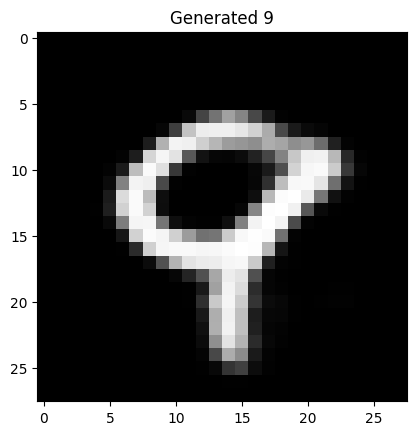

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- 1. The Late Fusion Model ---
class LateFusionCVAE(nn.Module):
    def __init__(self, num_classes=10, latent_dim=20):
        super(LateFusionCVAE, self).__init__()
        
        # --- ENCODER ---
        # Input channels = 1 (just the grayscale image)
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1) # 28 -> 14
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # 14 -> 7
        
        # Feature size: 64 channels * 7 * 7 pixels = 3136
        # We concatenate the 10 class labels to these features
        self.fc_input_dim = 3136 + num_classes
        
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)
        
        # --- DECODER ---
        # Input: Latent Vector (20) + Class Label (10)
        self.dec_fc = nn.Linear(latent_dim + num_classes, 3136)
        
        # We reshape the linear output back to (64, 7, 7) before upsampling
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1) # 7 -> 14
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # 14 -> 28

    def encode(self, x, c):
        # 1. Convs first
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        
        # 2. Flatten
        h = h.view(-1, 3136)
        
        # 3. Concatenate Label (Late Fusion)
        inputs = torch.cat([h, c], dim=1)
        
        return self.fc_mu(inputs), self.fc_logvar(inputs)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # 1. Concatenate Latent + Label
        inputs = torch.cat([z, c], dim=1)
        
        # 2. Project and Reshape
        h = F.relu(self.dec_fc(inputs))
        h = h.view(-1, 64, 7, 7) 
        
        # 3. Deconv
        h = F.relu(self.dec_conv1(h))
        return torch.sigmoid(self.dec_conv2(h))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

# --- 2. Setup & Training ---

# Device handling
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Loading
batch_size = 128
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# Initialize Model
model = LateFusionCVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    # Flatten both to (Batch, 784) for BCE calculation
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def one_hot(labels, num_classes):
    return torch.eye(num_classes, device=labels.device)[labels]

# Training Loop
print("Starting training...")
model.train()
for epoch in range(25): # 15 epochs should get you well below 100 loss
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        # Create condition
        c = one_hot(labels, 10)
        
        optimizer.zero_grad()
        
        # Forward
        recon_batch, mu, logvar = model(data, c)
        
        # Loss
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch: {epoch+1} Average loss: {train_loss / len(train_loader.dataset):.4f}')

print("Training complete!")

# --- 3. Visualization ---
def visualize_result(digit):
    model.eval()
    with torch.no_grad():
        # Sample random noise
        z = torch.randn(1, 20).to(device)
        
        # Create label
        c = torch.tensor([digit]).to(device)
        c = one_hot(c, 10)
        
        # Generate
        img = model.decode(z, c).cpu().view(28, 28)
        
        plt.imshow(img, cmap='gray')
        plt.title(f"Generated {digit}")
        plt.show()

# Generate a random '9'
visualize_result(9)

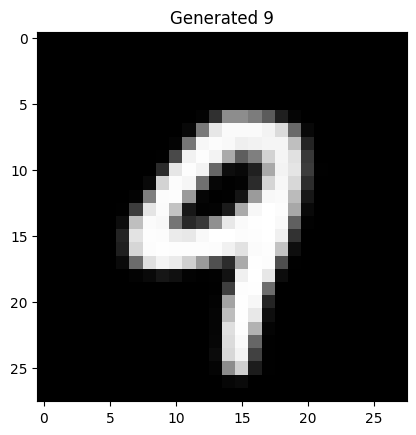

In [24]:
visualize_result(9)

Running t-SNE... this might take a moment.


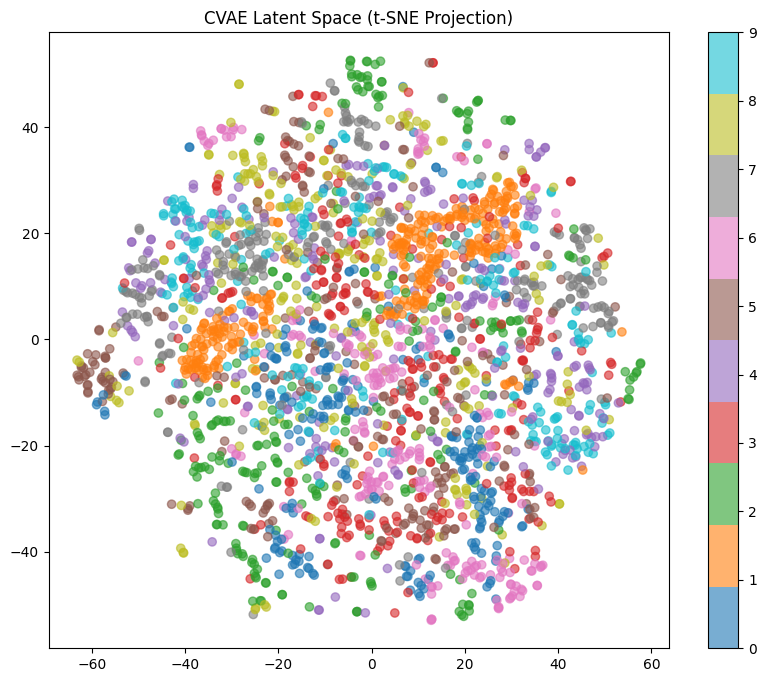

In [25]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space_tsne(model, data_loader, num_batches=20):
    model.eval()
    
    latent_vectors = []
    labels_list = []
    
    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            if i >= num_batches: break
            
            data = data.to(device)
            c = one_hot(labels.to(device), 10)
            
            # Get the latent vector (mu)
            mu, _ = model.encode(data, c)
            
            latent_vectors.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())
            
    # Concatenate
    X = np.concatenate(latent_vectors, axis=0)
    Y = np.concatenate(labels_list, axis=0)
    
    # Run t-SNE (Project 20D -> 2D)
    print("Running t-SNE... this might take a moment.")
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title("CVAE Latent Space (t-SNE Projection)")
    plt.show()

# Run it
plot_latent_space_tsne(model, train_loader)
